In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import sys
import os

import matplotlib.pyplot as plt
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from random import randrange

import boto3

In [4]:
pwd

'/root/emotional-recognition/notebooks/low_level/supervised_learning/audio'

In [5]:
os.chdir('/root/emotional-recognition/notebooks/low_level/supervised_learning/audio/')

In [6]:
pwd

'/root/emotional-recognition/notebooks/low_level/supervised_learning/audio'

In [7]:
module_path = os.path.abspath(os.path.join('../../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [8]:
from label_transforms import *

In [9]:
AUDIO_LLD_COLS = [
    "Loudness_sma3",
    "alphaRatio_sma3",
    "hammarbergIndex_sma3",
    "slope0-500_sma3",
    "slope500-1500_sma3",
    "spectralFlux_sma3",
    "mfcc1_sma3", "mfcc2_sma3",
    "mfcc3_sma3", "mfcc4_sma3",
    "F0semitoneFrom27.5Hz_sma3nz",
    "jitterLocal_sma3nz",
    "shimmerLocaldB_sma3nz",
    "HNRdBACF_sma3nz",
    "logRelF0-H1-H2_sma3nz",
    "logRelF0-H1-A3_sma3nz",
    "F1frequency_sma3nz",
    "F1bandwidth_sma3nz",
    "F1amplitudeLogRelF0_sma3nz",
    "F2frequency_sma3nz",
    "F2bandwidth_sma3nz",
    "F2amplitudeLogRelF0_sma3nz",
    "F3frequency_sma3nz",
    "F3bandwidth_sma3nz",
    "F3amplitudeLogRelF0_sma3nz"
]

In [10]:
from s3fs.core import S3FileSystem
s3 = S3FileSystem()
from sagemaker import get_execution_role

role = get_execution_role()
bucket='files-and-examples-01'
file = 'datasets/su_dataset/audio/audio_time_series.npz'

path = s3.open('s3://{}/{}'.format(bucket, file))

f = np.load(path, 'r')
x = f['x']
y = f['y']

In [11]:
x.shape

(11062, 3094, 25)

In [12]:
y.shape

(11062,)

In [13]:
ang_idx = emotion_abr_to_emotion_id["ang"]
print("ang_idx:", ang_idx)
hap_idx = emotion_abr_to_emotion_id["hap"]
print("hap_idx:", hap_idx)

ang_idx: 12
hap_idx: 33


In [14]:
x_ang_hap = x[np.where((y == ang_idx) | (y == hap_idx))]
y_ang_hap = y[np.where((y == ang_idx) | (y == hap_idx))]

In [15]:
y_ang_hap[y_ang_hap == ang_idx] = 0
y_ang_hap[y_ang_hap == hap_idx] = 1

In [19]:
x_ang_hap.shape

(500, 3094, 25)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(x_ang_hap, y_ang_hap, test_size=0.3)

In [23]:
X_train.shape

(350, 3094, 25)

In [25]:
y_train

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,

In [28]:
seq_len = 3094
n_cols = 25

model = keras.Sequential(
    [
        layers.LSTM(units=100,
                   return_sequences=True,
                   input_shape=(seq_len, n_cols)),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(100, activation="relu"),
        layers.Dense(2, activation="sigmoid")
    ]
)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 3094, 100)         50400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3094, 100)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 309400)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30940100  
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 202       
Total params: 30,990,702
Trainable params: 30,990,702
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.fit(X_train, y_train, batch_size=100, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
4/4 [==============================] - 2s 329ms/step - loss: 53.9580 - accuracy: 0.5371 - val_loss: 37.8186 - val_accuracy: 0.4800
Epoch 2/50
4/4 [==============================] - 1s 188ms/step - loss: 31.7142 - accuracy: 0.5086 - val_loss: 13.9138 - val_accuracy: 0.4800
Epoch 3/50
4/4 [==============================] - 1s 181ms/step - loss: 5.4357 - accuracy: 0.4857 - val_loss: 0.6930 - val_accuracy: 0.5200
Epoch 4/50
4/4 [==============================] - 1s 183ms/step - loss: 0.6932 - accuracy: 0.4914 - val_loss: 0.6929 - val_accuracy: 0.5200
Epoch 5/50
4/4 [==============================] - 1s 183ms/step - loss: 0.6933 - accuracy: 0.4914 - val_loss: 0.6929 - val_accuracy: 0.5200
Epoch 6/50
4/4 [==============================] - 1s 188ms/step - loss: 0.6933 - accuracy: 0.4914 - val_loss: 0.6929 - val_accuracy: 0.5200
Epoch 7/50
4/4 [==============================] - 1s 181ms/step - loss: 0.6933 - accuracy: 0.4914 - val_loss: 0.6929 - val_accuracy: 0.5200
Epoch 8/50
4/4 [

KeyboardInterrupt: 

# Exploration 

In [24]:
masked_x = ma.masked_where(x == -1000, x)

In [25]:
anger_id = 12
happiness_id = 33

In [26]:
x_ang = masked_x[np.where(y == 12)]
x_hap = masked_x[np.where(y == 33)]

Loudness_sma3


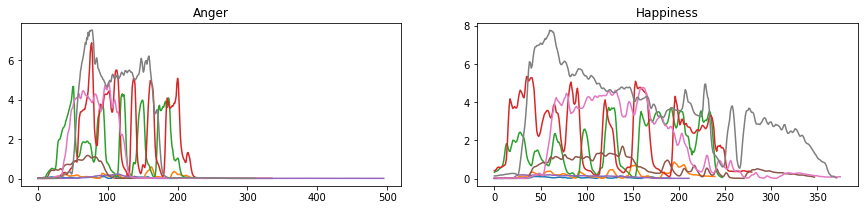

alphaRatio_sma3


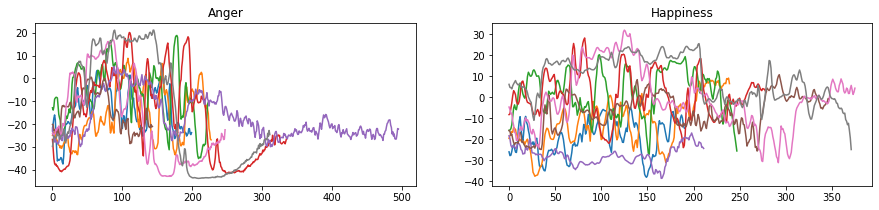

hammarbergIndex_sma3


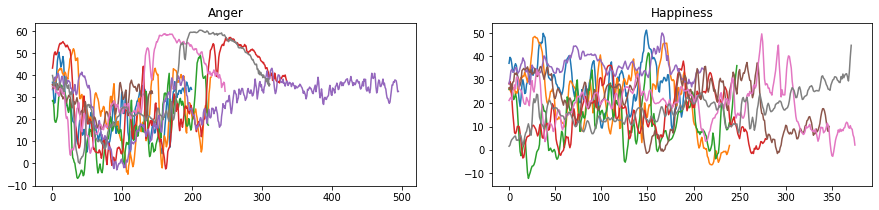

slope0-500_sma3


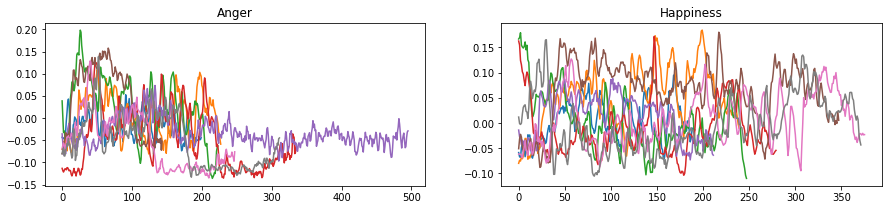

slope500-1500_sma3


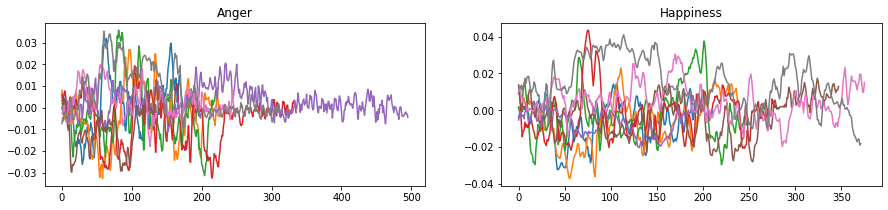

spectralFlux_sma3


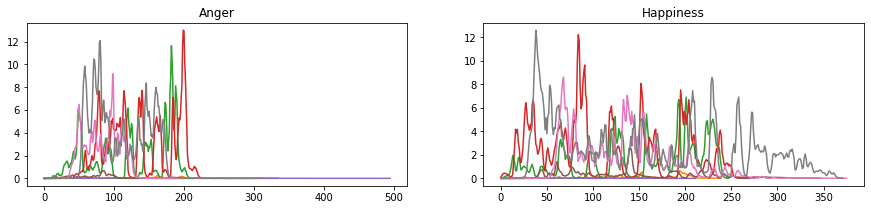

mfcc1_sma3


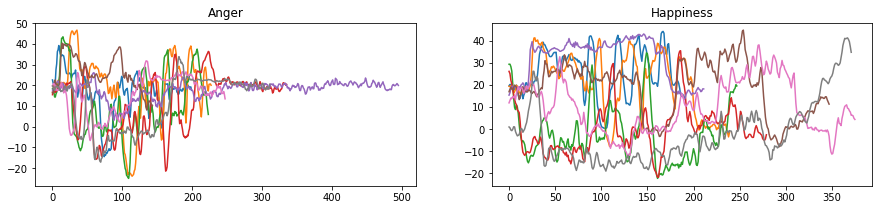

mfcc2_sma3


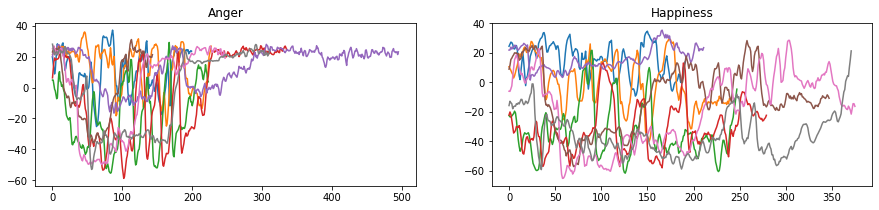

mfcc3_sma3


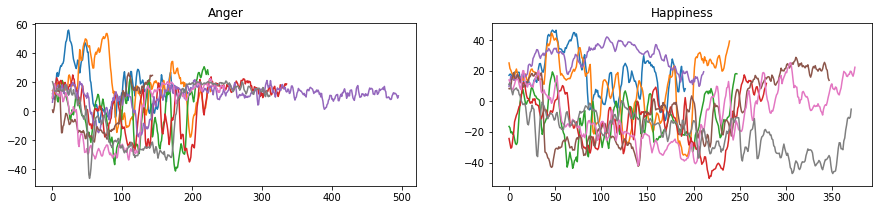

mfcc4_sma3


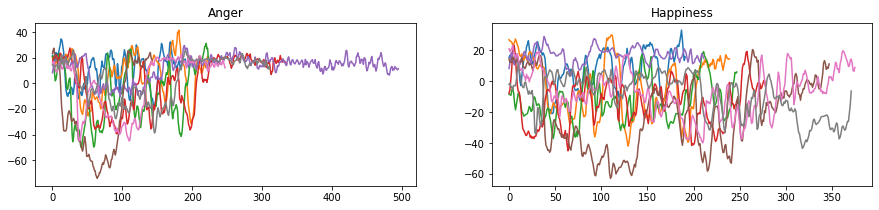

F0semitoneFrom27.5Hz_sma3nz


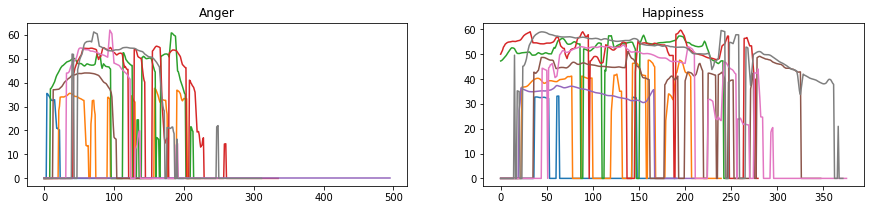

jitterLocal_sma3nz


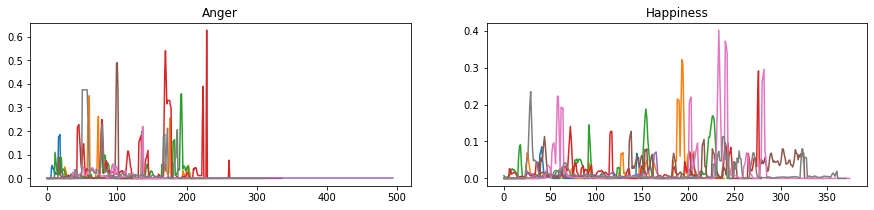

shimmerLocaldB_sma3nz


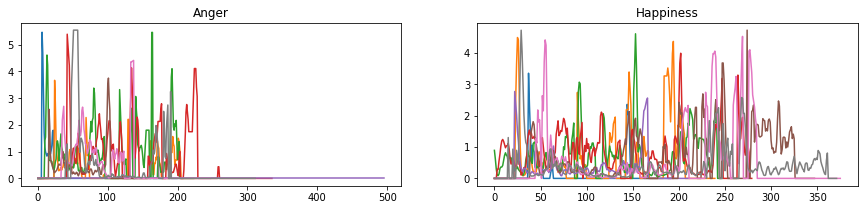

HNRdBACF_sma3nz


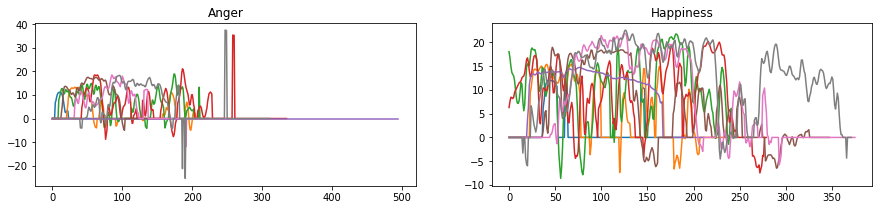

logRelF0-H1-H2_sma3nz


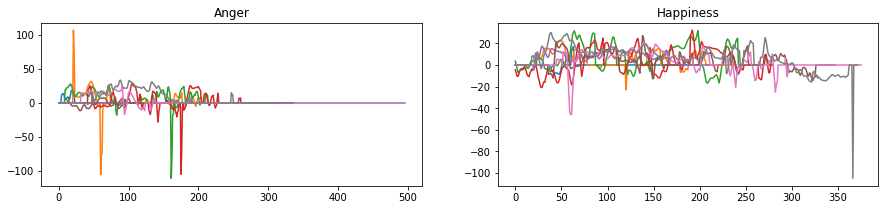

logRelF0-H1-A3_sma3nz


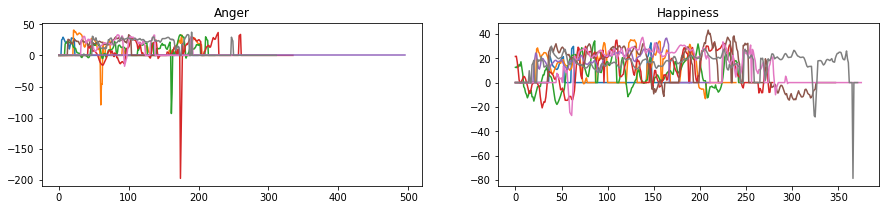

F1frequency_sma3nz


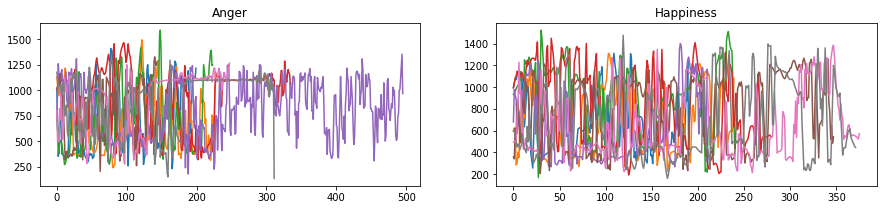

F1bandwidth_sma3nz


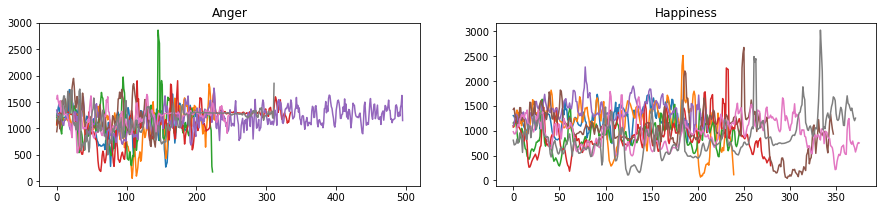

F1amplitudeLogRelF0_sma3nz


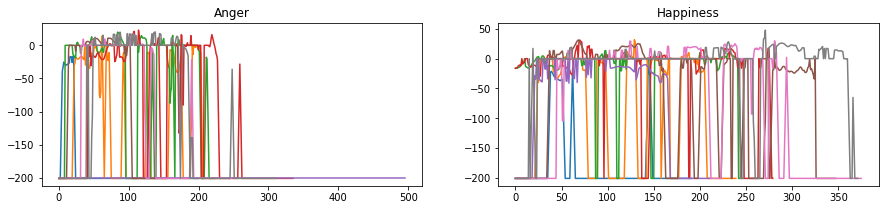

F2frequency_sma3nz


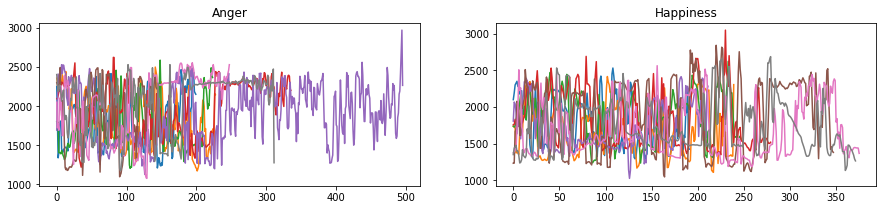

F2bandwidth_sma3nz


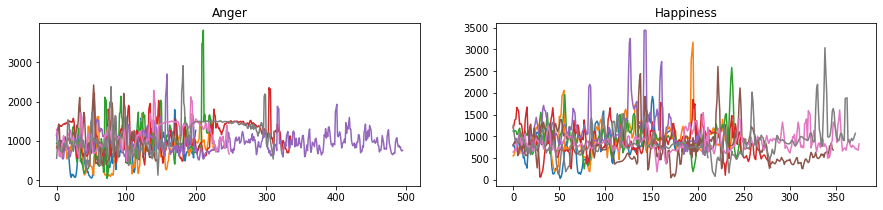

F2amplitudeLogRelF0_sma3nz


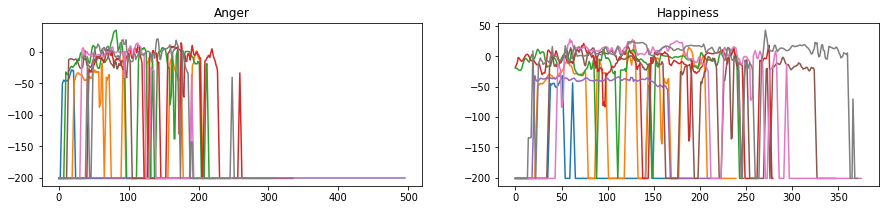

F3frequency_sma3nz


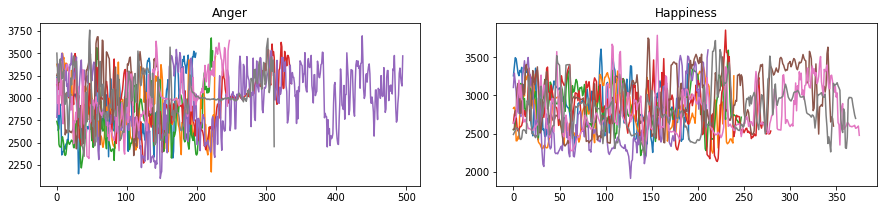

F3bandwidth_sma3nz


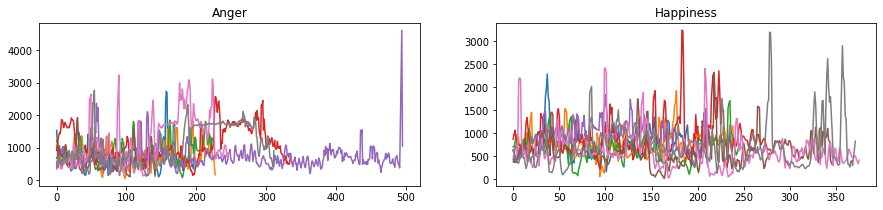

F3amplitudeLogRelF0_sma3nz


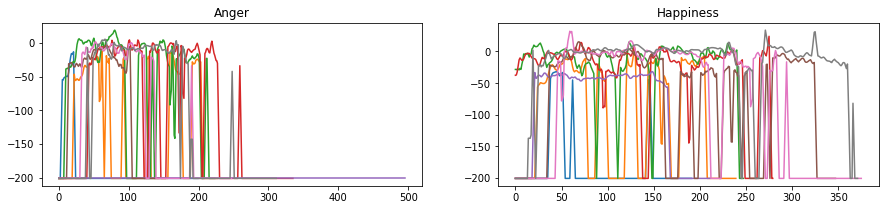

In [27]:
for col_idx, col in enumerate(AUDIO_LLD_COLS):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
    for vid_idx in range(8):
        axes[0].set_title("Anger")
        axes[1].set_title("Happiness")
        ts_ang = x_ang[vid_idx, :1000, col_idx]
        ts_hap = x_hap[vid_idx, :1000, col_idx]
        axes[0].plot(ts_ang)
        axes[1].plot(ts_hap)
    print(col)
    plt.show()

In [28]:
masked_x = None

# LSTM Networks

In [13]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [14]:
X_train.shape

(246, 2164, 25)

In [15]:
X_test.shape

(106, 2164, 25)

In [16]:
y_train.shape

(246,)

In [17]:
y_test.shape

(106,)

In [23]:
y_train

array([38, 29, 24,  7, 22, 42, 15, 23, 27, 41, 36, 14, 23,  8, 12, 38, 43,
       30, 19, 22, 36, 32,  2,  1, 28, 11, 42, 33, 16, 34, 42, 27, 35,  6,
       32, 20, 31,  9, 18, 21, 27, 18, 11, 22, 18,  1, 31, 10, 17, 35, 19,
       19,  3, 40, 20,  3, 35, 12, 36,  9, 17,  7, 17, 29, 29, 29, 33, 16,
       11, 21,  3,  9, 21, 42, 15,  5, 36,  4,  4,  4, 30, 43, 12,  8,  9,
        1, 32, 24, 16,  0, 12, 10, 15,  1, 22, 23, 43, 33, 37, 25,  0, 13,
       16, 20, 20,  7, 24, 18, 37, 26, 11, 41, 31, 35, 10, 13, 34, 19, 34,
       26, 22, 43, 12,  8,  5, 25, 42, 18, 40, 32, 39, 16,  5,  3, 21,  3,
       17, 28, 17, 39,  6, 29, 12,  8, 34,  9, 13,  1, 31,  8, 38, 11, 13,
       15,  6, 25, 14, 26, 40, 37, 11,  8, 36, 27, 20,  0, 14, 27, 20, 39,
        2,  3, 26, 25, 39, 30,  4, 29, 25, 40, 27,  6, 40, 14, 16, 28, 23,
       41,  6, 28, 28, 13, 21, 14, 13, 15, 23,  2,  4,  2, 32, 42, 41, 43,
       17, 15,  1,  2, 11, 19,  2, 38, 38, 21, 33,  5, 38, 18, 42, 43, 10,
       33,  7, 39, 19,  5

In [24]:
seq_len = 2164
n_cols = 25

model = keras.Sequential(
    [
        layers.LSTM(units=100,
                   return_sequences=True,
                   input_shape=(seq_len, 25)),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(100, activation="relu"),
        layers.Dense(44, activation="sigmoid")
    ]
)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 2164, 100)         50400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 2164, 100)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 216400)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               21640100  
_________________________________________________________________
dense_5 (Dense)              (None, 44)                4444      
Total params: 21,694,944
Trainable params: 21,694,944
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit(X_train, y_train, batch_size=100, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
3/3 [==============================] - 2s 336ms/step - loss: 9.2384 - accuracy: 0.0203 - val_loss: 12.6918 - val_accuracy: 0.0283
Epoch 2/50
3/3 [==============================] - 0s 141ms/step - loss: 8.9074 - accuracy: 0.0447 - val_loss: 6.0774 - val_accuracy: 0.0377
Epoch 3/50
3/3 [==============================] - 0s 140ms/step - loss: 4.2129 - accuracy: 0.0528 - val_loss: 4.5742 - val_accuracy: 0.0283
Epoch 4/50
3/3 [==============================] - 0s 140ms/step - loss: 3.6479 - accuracy: 0.0772 - val_loss: 4.2073 - val_accuracy: 0.0189
Epoch 5/50
3/3 [==============================] - 0s 145ms/step - loss: 3.5849 - accuracy: 0.0976 - val_loss: 4.0464 - val_accuracy: 0.0283
Epoch 6/50
3/3 [==============================] - 0s 141ms/step - loss: 3.4122 - accuracy: 0.1260 - val_loss: 4.1060 - val_accuracy: 0.0283
Epoch 7/50
3/3 [==============================] - 0s 141ms/step - loss: 3.2974 - accuracy: 0.1341 - val_loss: 4.1098 - val_accuracy: 0.0283
Epoch 8/50
3/3 [===

In [27]:
ang_idx = emotion_abr_to_emotion_id["ang"]
print("ang_idx:", ang_idx)
hap_idx = emotion_abr_to_emotion_id["hap"]
print("hap_idx:", hap_idx)

ang_idx: 12
hap_idx: 33


In [28]:
x_ang_hap = x[np.where((y == ang_idx) | (y == hap_idx))]
y_ang_hap = y[np.where((y == ang_idx) | (y == hap_idx))]

In [29]:
y_ang_hap[y_ang_hap == ang_idx] = 0
y_ang_hap[y_ang_hap == hap_idx] = 1

In [31]:
X_train, X_test, y_train, y_test = train_test_split(x_ang_hap, y_ang_hap, test_size=0.3)

In [33]:
X_train.shape

(11, 2164, 25)

In [ ]:
seq_len = 2164
n_cols = 25

model = keras.Sequential(
    [
        layers.LSTM(units=100,
                   return_sequences=True,
                   input_shape=(seq_len, 25)),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(100, activation="relu"),
        layers.Dense(44, activation="sigmoid")
    ]
)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

# Masking

In [17]:
seq_len = 3094
n_cols = 25

model = keras.Sequential(
    [
        layers.Masking(mask_value = -1000, input_shape=(seq_len, n_cols)),
        layers.LSTM(units=100,
                   return_sequences=True,
                   input_shape=(seq_len, n_cols)),
        layers.Dropout(0.7),
        layers.Flatten(),
        layers.Dense(100, activation="relu"),
        layers.Dense(44, activation="sigmoid")
    ]
)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 3094, 25)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 3094, 100)         50400     
_________________________________________________________________
dropout (Dropout)            (None, 3094, 100)         0         
_________________________________________________________________
flatten (Flatten)            (None, 309400)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               30940100  
_________________________________________________________________
dense_1 (Dense)              (None, 44)                4444      
Total params: 30,994,944
Trainable params: 30,994,944
Non-trainable params: 0
____________________________________________

In [18]:
model.fit(X_train, y_train, batch_size=50, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-11-04 12:54:42.463 tensorflow-2-6-gpu--ml-g4dn-xlarge-6f7b193ebf85c4ca6ed374f84b1e:166 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-04 12:54:42.523 tensorflow-2-6-gpu--ml-g4dn-xlarge-6f7b193ebf85c4ca6ed374f84b1e:166 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
155/155 [==============================] - 23s 102ms/step - loss: 3.8691 - accuracy: 0.0191 - val_loss: 3.7863 - val_accuracy: 0.0238
Epoch 2/50
155/155 [==============================] - 13s 83ms/step - loss: 3.7835 - accuracy: 0.0227 - val_loss: 3.7896 - val_accuracy: 0.0190
Epoch 3/50
155/155 

KeyboardInterrupt: 